In [ ]:
!pip install -q transformers tensorflow sklearn PyDrive

## Dataset loading options

From Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

From local storage

In [ ]:
from google.colab import files

uploaded = files.upload()
# Assume che il CSV sia il primo file caricato
print(f"Select train dataset .csv from your local storage:. . .")
train_data_filename = list(uploaded.keys())[0]

In [ ]:
uploaded = files.upload()
# Assume che il CSV sia il primo file caricato
print(f"Select test dataset .csv from your local storage:. . .")
test_data_filename = list(uploaded.keys())[0]

## Import Libraries

In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel

## Model settings

In [ ]:
MODEL_NAME    = "roberta-base"
MAX_LEN       = 128
BATCH_SIZE    = 16
EPOCHS        = 3
LEARNING_RATE = 2e-5
NUM_LABELS    = 2
RANDOM_STATE = 42

In [2]:
train_data_filename = "../Dataset/amazon_review_full_csv/train.csv"
test_data_filename = "../Dataset/amazon_review_full_csv/test.csv"

## Train dataset loading

In [3]:
print(f"Loading dataset from: {train_data_filename}")

df_train = pd.read_csv(
    train_data_filename,
    header=None,
    names=['label', 'title', 'text'],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  
    )

Loading dataset from: ../Dataset/amazon_review_full_csv/train.csv


In [4]:
df_train.describe()

,label
count,2.999746e+06
mean,3.000022e+00
std,1.414218e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [11]:
df_train.shape[0]

2999746

In [ ]:
df_train.isna().sum()

label      0
title    188
text       0
dtype: int64

Drop rows with at least a null value

In [13]:
df_train.dropna(inplace=True)
df_train.shape[0]

2999558

In [19]:
df_train.isna().sum()

label    0
title    0
text     0
dtype: int64

In [15]:
df_test = pd.read_csv(
    test_data_filename,
    header=None,
    names=['label', 'title', 'text'],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    engine='python',
    encoding='utf-8',
    on_bad_lines='skip'  
    )

In [16]:
df_test.describe()

,label
count,649954.000000
mean,3.000011
std,1.414217
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [17]:
df_test.shape[0]

649954

In [ ]:
df_test.isna().sum()

label     0
title    26
text      0
dtype: int64

In [23]:
df_test.dropna(inplace=True)

In [24]:
df_test.isna().sum()

label    0
title    0
text     0
dtype: int64

In [25]:
df_test.shape[0]

649928

## Ratings mapping

In [26]:
# Function to convert ratings (1-5) into 3 classes:
def map_rating(row):
    rating = row['label']
    if rating <= 2:
        return 0  # negative
    elif rating == 3:
        return 1  # neutral
    else:
        return 2  # positive

In [ ]:
df_train_mapped = df_train.copy(deep=True)

df_train_mapped['sentiment'] = df_train_mapped.apply(map_rating, axis=1)

df_train_mapped.drop(columns=["label"], inplace=True)

display(df_train_mapped.head())

,title,text,sentiment
0,more like funchuck,Gave this to my dad for a gag gift after direc...,1
1,Inspiring,I hope a lot of people hear this cd. We need m...,2
2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,2
3,Chrono Cross OST,The music of Yasunori Misuda is without questi...,2
4,Too good to be true,Probably the greatest soundtrack in history! U...,2


In [ ]:
df_train_mapped['review'] = df_train_mapped['title'].fillna('') + ' ' + df_train_mapped['text'].fillna('')
df_train_sampled = df_train_mapped.sample(n=1000000, random_state=RANDOM_STATE)
X = df_train_sampled['review']
y = df_train_sampled['sentiment'].values

## NLTK libraries

In [30]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('popular')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lorisgiunta/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lorisgiunta/nltk_data...
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/lorisgiunta/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/lorisgiunta/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/lorisgiunta/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/lorisgiunta/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/lorisgiunta/nl

True

In [ ]:
X = [text.replace('\n', ' ') for text in X] 
X = [text.lower() for text in X]

## Setting Tokenizer

This approach uses the same tokenizer used during the model `MODEL_NAME` pretraining. This allow to preserve the context and language semantics.

`AutoTokenizer` is able to infer automatically the model used.

For example we can possible use RobertaTokenizer, but only if we are sure that we'll use RoBERTa model.

## Analyze tokens distribution to choose the best trade-off for MAX_LEN.
The idea is to use the 95th percentile to reduce padding and truncate only outliers.

In [ ]:
import numpy as np

# 50000 samples are good enough to get a stable estimation of tokens distribution
sample_texts = X.sample(n=50000, random_state=RANDOM_STATE).tolist()

# Tokenizza solo per analisi (senza padding)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
token_lens = [len(tokenizer.tokenize(t)) for t in sample_texts]


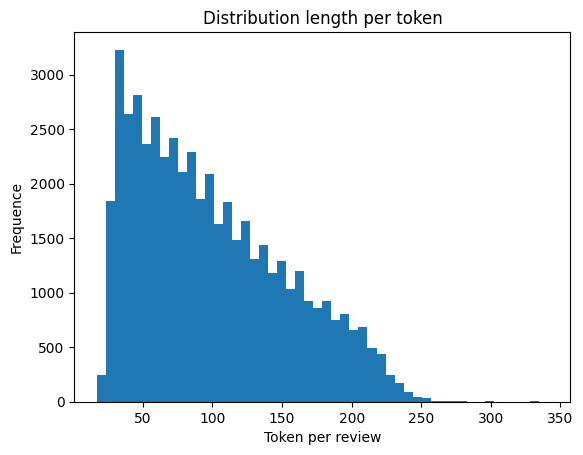

In [40]:
import matplotlib.pyplot as plt

plt.hist(token_lens, bins=50)
plt.title("Distribution length per token")
plt.xlabel("Token per review")
plt.ylabel("Frequence")
plt.show()

In [39]:
print("Token length stats:")
print(f"Mean: {np.mean(token_lens):.1f}")
print(f"95th percentile: {np.percentile(token_lens, 95):.0f}")
print(f"Max: {np.max(token_lens)}")

Token length stats:
Mean: 99.5
95th percentile: 202
Max: 341


The 95th percentile of tokenized length is 202, meaning that 95% of the reviews are shorter than this threshold.

To balance memory efficiency and minimize information loss, we set `MAX_LEN = 210`:
- This truncates only the top 5% longest reviews (outliers).
- It reduces unnecessary padding for the remaining 95% of the data.
- It ensures consistent input size for the model without significant loss of content.

In [ ]:
MAX_LEN = 210

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_texts(texts):
    return tokenizer(
        texts.tolist(),
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )


In [ ]:
texts = X.tolist()
encodings = tokenizer(
    texts,
    max_length=MAX_LEN,
    truncation=True,
    padding='max_length',
    return_tensors='tf'
)


In [ ]:
ds = tf.data.Dataset.from_tensor_slices((
    {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask']},
    y
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
